In [64]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import fix_yahoo_finance
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Stock Portfolio Optimization

# Introduction
Imagine you are back in the beginning of June 2009, the S&P 500 has lost nearly half of its market value in the past year and a half in one of the worst bear markets in U.S. history. Investors are panicked and sentiment is low.  However, there is a glimmer of hope.  The S&P 500 has had tree consequtive months of positive returns, the first such achievement in a year.

Feeling the urge to buy back into the market, you decide that you need to decide on the right allocation of assets for your portfolio.

How can you choose which sectors to invest in?

In this analysis, I seek to demonstrate the use of some portfolio optimization techniques and tools such as **Mean-Variance  Optimization (MVO)**, **Modern Portfolio Theory (MPT)**, **Monte Carlo Simulation** and the **Efficient Frontier**. You can find the GitHub repository with the Jupyter Notebook and data [here](https://github.com/CollierKing/Finance_Portfolio_Optimization).

## Objective
The goal of this analysis is to backtest the results of MVO-backed, Monte Carlo-simulated portfolio strategies on real-world stock market return data. The recommendations of the portfolio optimization process will stem from data spanning December 1998 to May 2009.  We will see if this time period of data provides a worthy source for us to design our portfolio for June 2009 to present.

# Data Source

The components of the portfolio we will consider are comprised of ETFs representing nine different sectors in the U.S. economy.  In the analysis, we will assemble our portfolios using different weightings of the following ETFs:
* **XLY** (Consumer Discretionary Select Sector SPDR® Fund)
* **XLP** (Consumer Staples Select Sector SPDR® Fund)
* **XLE** (Energy Select Sector SPDR® Fund)
* **XLF** (Financial Select Sector SPDR® Fund)
* **XLV** (Health Care Select Sector SPDR® Fund)
* **XLI** (Industrial Select Sector SPDR® Fund)
* **XLB** (Materials Select Sector SPDR® Fund)
* **XLK** (Technology Select Sector SPDR® Fund)
* **XLU** (Utilities Select Sector SPDR® Fund)

In [2]:
# XLY = web.get_data_yahoo('XLY',start='1998-12-16')['Adj Close']
# time.sleep(5)
# XLP = web.get_data_yahoo('XLP',start='1998-12-16')['Adj Close']
# time.sleep(5)
# XLE = web.get_data_yahoo('XLE',start='1998-12-16')['Adj Close']
# time.sleep(5)
# XLF = web.get_data_yahoo('XLF',start='1998-12-16')['Adj Close']
# time.sleep(5)
# XLV = web.get_data_yahoo('XLV',start='1998-12-16')['Adj Close']
# time.sleep(5)
# XLI = web.get_data_yahoo('XLI',start='1998-12-16')['Adj Close']
# time.sleep(5)
# XLB = web.get_data_yahoo('XLB',start='1998-12-16')['Adj Close']
# time.sleep(5)
# XLK = web.get_data_yahoo('XLK',start='1998-12-16')['Adj Close']
# time.sleep(5)
# XLU = web.get_data_yahoo('XLU',start='1998-12-16')['Adj Close']
# time.sleep(5)

# data = pd.concat([XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLK,XLU],axis=1)
# data.columns = ['XLY','XLP','XLE','XLF','XLV','XLI','XLB','XLK','XLU']
# noa = data.shape[1]

# data.to_csv("C:/Users/David/Dropbox/Skills/Python/Projects/Stocks/Finance_Portfolio_Optimization/quotes.csv")

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/CollierKing/Finance_Portfolio_Optimization/master/quotes.csv",index_col='Date')
noa = data.shape[1]

## Visualizing Performance

Below we see a historical performance comparison accross the nine indexes over a nearly 20-year period spanning December 1998 to October 2017.  From this chart we see both the Dot-Com bubble burst of 1999-2000 and the Financial Crisis of 2008.

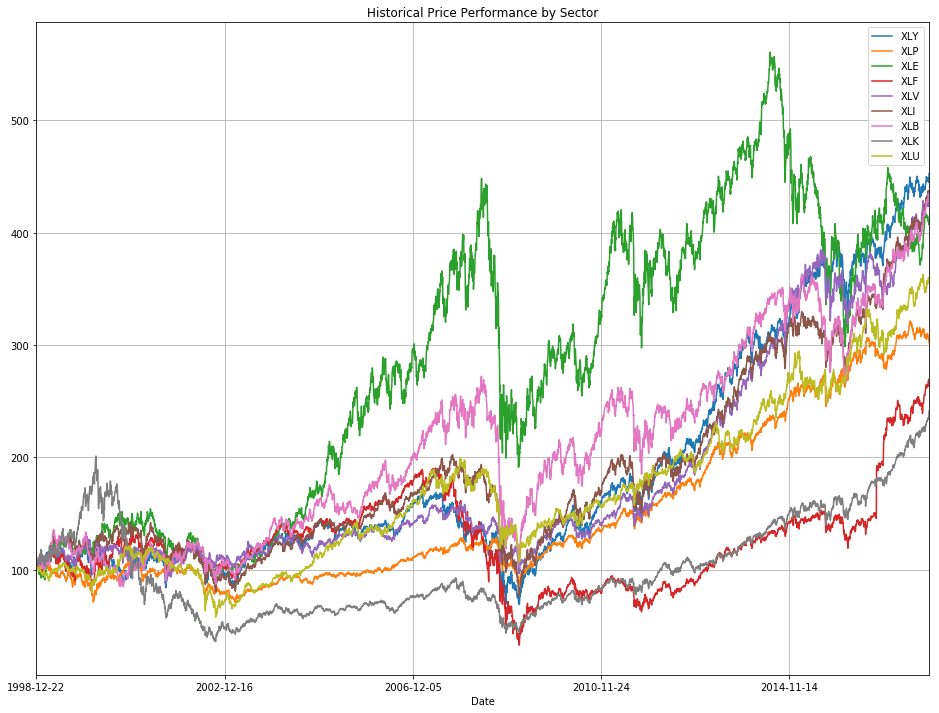

In [4]:
(data/data.iloc[0]*100).plot(figsize=(16, 12),title="Historical Price Performance by Sector");
plt.grid(True)

Now, we calculate daily log returns and annualize them across the 252 trading days per year.

We see that XLY (Consumer Discretionary) has the highest annualized return, followed by a near even split amongst XLB (Basic Materials), XLI (Industrials), XLV (Healthcare) and XLE (Energy).

In [5]:
rets = np.log(data/data.shift(1))
pd.DataFrame(rets.mean()*252).sort_values(by=0,ascending=False)

,0
XLY,0.080251
XLB,0.078166
XLI,0.077985
XLV,0.076710
XLE,0.074780
XLU,0.068095
XLP,0.058742
XLF,0.052644
XLK,0.046808


## Sector Correlations

Let's also look at the correlation matrix of the returns across the different sectors:

We see the following:

* XLY has a strong correlation with XLF
* XLY has a strong correlation with XLI
* XLF has a strong correlation with XLI
* XLV has a strong correlation with XLI
* XLI has a strong correlation with XLB
* XLI has a strong correlation with XLK

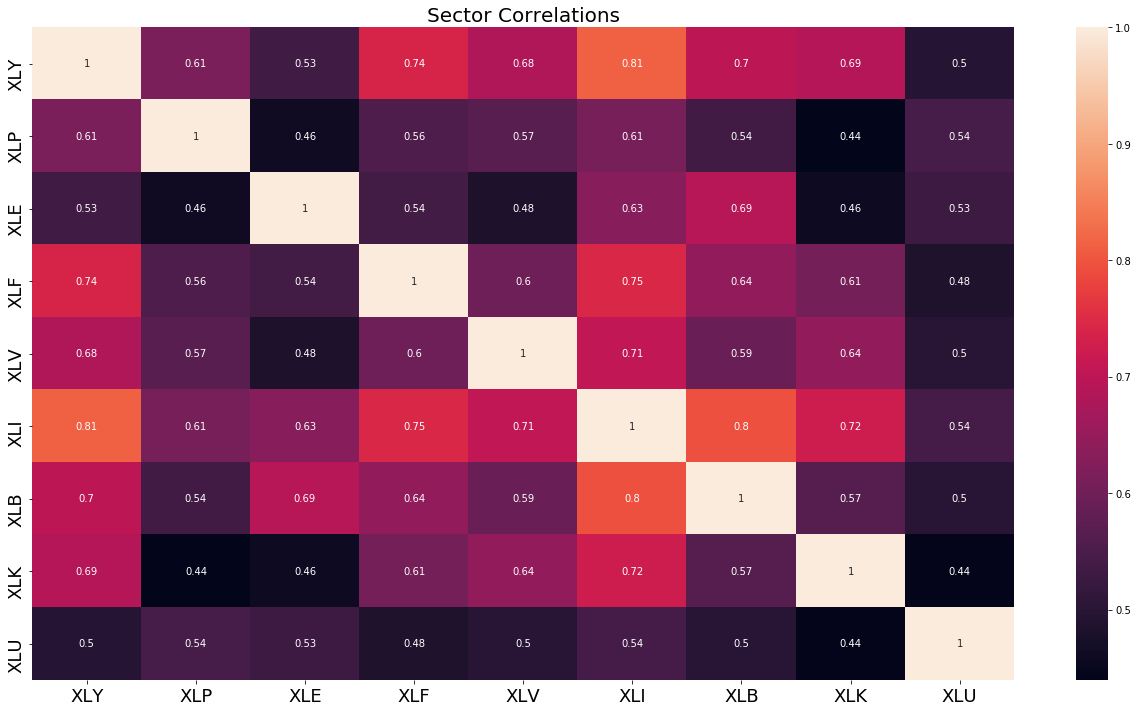

In [6]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(22,12)) 
ax = sns.heatmap(rets.corr(),annot=True);

ax.set_title("Sector Correlations",fontsize=20);
ax.yaxis.set_tick_params(labelsize=18);
ax.xaxis.set_tick_params(labelsize=18);

## Normality of Returns

Many financial frameworks, including mean-variance optimization assume the normality of returns of securities.  For this reason, it is worth checking the normality of returns of the various ETFs in our dataset.

From the below plot, we can see that these securities seem to have normally distributed returns.

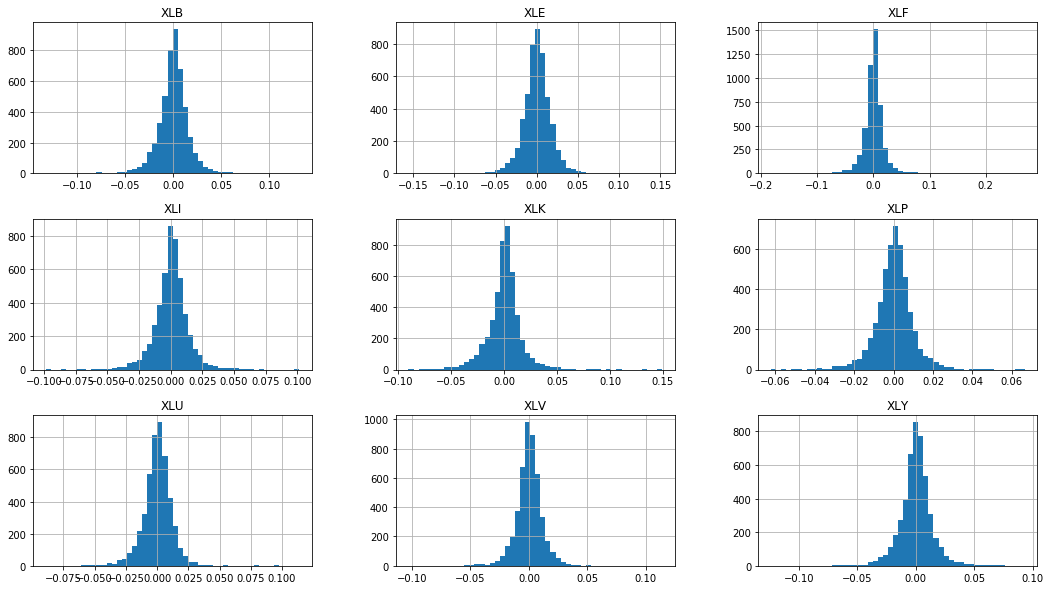

In [7]:
rets.hist(bins=50,figsize=(18,10));

However, upon execution of a formal normality test, we observe a p-value near zero indicating that we must reject the null hypothesis that the given sample comes from a normal distribution.

In [8]:
from scipy.stats import normaltest
normaltest(rets['XLY'].dropna())

NormaltestResult(statistic=624.51088078986118, pvalue=2.4501083602685089e-136)

This revelation shows that, in general, the assumption of normality of stock market returns cannot be relied upon.  In such cases, it is typically necessary to employ modeling techniques which account for "fat tails" in the return distribution. Two such techniques are **Stochastic Volatility Models** which you can read more about [here](https://en.wikipedia.org/wiki/Stochastic_volatility) and **Jump Diffusion** models which you can read more about [here](https://en.wikipedia.org/wiki/Jump_diffusion). You can also read more about attempts to improve the framework model used in this analysis, Modern Portfolio Theory, to account for more realistic assumptions [here](https://en.wikipedia.org/wiki/Post-modern_portfolio_theory). However, these models are beyond the scope of this analysis, and so we will follow the assumption that our stock returns are normally distributed.

## Training & Test Datasets

In the introduction, we stated that our problem was how to plan for the future (June 2009) and onwards.  For this reason we will split our dataset into two parts.

* The Training set will comprise data from 1998 to end of May 2009
* The Test set will comprise data from June 2009 to present (October 2017)

In [9]:
rets_train = np.log(data[data.index<"2009-06-01 00:00:00"]/data[data.index<"2009-06-01 00:00:00"].shift(1))
rets_test = rets[~rets.index.isin(rets_train.index)]
print("Train Size: "+str(rets_train.shape[0]))
print("Test Size: "+str(rets_test.shape[0]))

Train Size: 2625
Test Size: 2118


# Mean-Variance Optimization

In this analysis we will employ **Single-Period Portfolio Mean-Variance Optimization**.  This strategy was pioneered by Harry Markowitz in the 1950s and is also known as **Modern Portfolio Theory (MPT)**.  The theory says that when stock returns are normally distributed, optimal portfolios become a function of **mean return**, **variance of return** and **covariance between different portfolio components**.  You can read more about Modern Portfolio Theory [here](https://en.wikipedia.org/wiki/Modern_portfolio_theory).

## Weights

To begin our simulation, we generate random portfolio security weights which sum to one.  For this analysis, we will keep the asset allocation relatively simple by only allowing positive weights, that is to say we are not allowing short positions.

Below is an example of randomly assigned portfolio weights.

In [10]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights_sample_df = pd.DataFrame(weights)
weights_sample_df = weights_sample_df.T
weights_sample_df.columns = data.columns
weights_sample_df

,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLK,XLU
0,0.156553,0.087736,0.07451,0.060629,0.139523,0.025754,0.148122,0.155086,0.152087


## Expected Return

The **Expected Return** is a probability weighted average of the possible returns for each asset. 

To derive the annualized average of our returns, we multply the product of our log returns and the weights of our portfolio securities by the number of trading days per year: 252.  

We see that for the entire dataset, spanning December 1998 to October 2017, the mean annualized expected return based on the randomly computed weights above is:

In [11]:
np.sum(rets.mean() * weights) * 252

0.068385867402846578

## Expected Variance & Standard Deviation

The **Expected Variance & Standard Deviation** represent the uncertainty about the outcome of our expected return.

More technically, the expected portfolio variance is the dot product of the weights vector and the annualized weighted covariance matrix.  For our data, the annualized expected variance of a portfolio with the above the weights is:

In [12]:
np.dot(weights.T,np.dot(rets.cov()*252,weights))

0.031725593017256568

The expected portfolio standard deviation is the square root of the expected porfolio variance and is synonymous to portfolio volatility:

In [13]:
np.sqrt(np.dot(weights.T,np.dot(rets.cov()*252,weights)))

0.17811679599986233

# Monte Carlo Simulation of Returns

For a given set of securities, we must discern what various risk-return profiles exist.  Our tool to this end is **Monte Carlo Simulation**. Monte Carlo Simulation is method of repeated random sampling from a probability distribution to obtain numerical results.  This method allows for a probabilistic approach to deterministic problems.  You can read more about Monte Carlo methods [here](https://en.wikipedia.org/wiki/Monte_Carlo_method).

With Monte Carlo simulation we will generate random portfolio weighting allocations and record the expected return and variance.

We calculate an expected portfolio return and expected portfolio standard deviation for each profile.
The resulting ratio of returns to standard deviations is referred to as the **Sharpe Ratio**.

The **Sharpe Ratio** is technically defined as "the expected excess return of the portfolio over the risk-free short rate, divided by the expected standard deviation of the portfolio.  The Sharpe Ratio has become one of the most widely used methods for calculating risk-adjusted return. In this analysis, we will ignore the risk-free short rate for simplicity, but in reality an approapriate discount rate should be applied.  You can read more about the Sharpe Ratio [here](http://www.investopedia.com/terms/s/sharperatio.asp).

In [14]:
prets = []
pvols = []
for p in range(100000):
    #initialize weights
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    #append returns to list
    prets.append(np.sum(rets_train.mean()*weights)*252)
    #append volatilities to list
    pvols.append(np.sqrt(np.dot(weights.T,
                               np.dot(rets_train.cov()*252,weights))))
    
    weights = pd.DataFrame(weights)
    weights = weights.T
    
    if p == 0:
        weights_all_train = weights
    else:
        weights_all_train = pd.concat([weights_all_train,weights])
    #append weights to dataframe

prets = np.array(prets)
pvols = np.array(pvols)
weights_all_train.columns = data.columns
weights_all_train['exp_return'] = prets
weights_all_train['exp_volatility'] = pvols
weights_all_train['sharpe_ratio'] = prets/pvols

## Distribution of Simulated Portfolios

Below we show the various portfolio profiles from the Monte Carlo simulation with their Expected Return, Expected Volatility and  accompanying Sharpe Ratios.

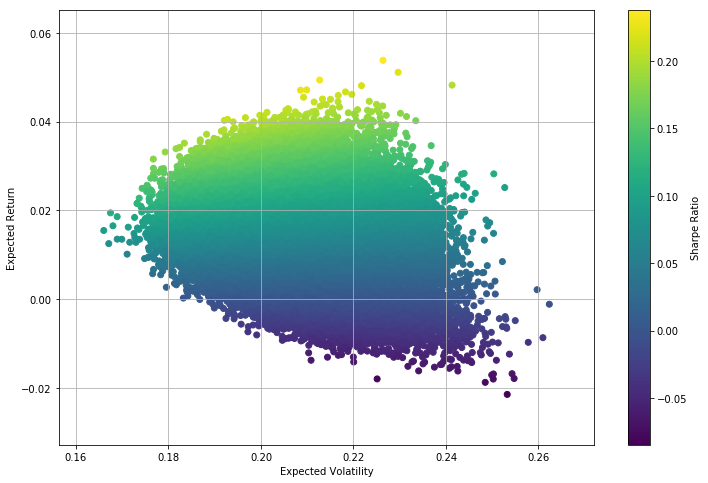

In [15]:
plt.figure(figsize=(12,8))
plt.scatter(pvols,prets,c=np.array(prets)/np.array(pvols),marker='o')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio');

# Portfolio Optimization
Now that we have visualized the possible portfolio profiles, we can mathematically determine which combination of weights leads to the "optimal" portfolio for our needs.  Our optimization tool for this analysis is the **optimize** method from the library **SciPy**. 

## Maximum Sharpe Ratio

Let's define our objective function as a function which takes an array of weights as an input and returns the Expected Return, Expected Volatility and Sharpe Ratio. 

In this case, we will seek to maximize the second element of the objective function's result, that is the Sharpe Ratio.  We will also pass a few constraints to the optimization which limits the sum of the weights to 1.

In [16]:
def statistics(weights):
    '''Returns portfolio statistics
    Parameters
    ==========
    pret : float
        expected portfolio return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    pret = np.sum(rets_train.mean()*weights)*252
    pvol = np.sqrt(np.dot(weights.T,np.dot(rets_train.cov()*252,weights)))
    return np.array([pret,pvol,pret/pvol])

In [17]:
import scipy.optimize as sco
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [18]:
#add constraint that all parameters (weights) add up to 1
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
#add constraint that each parameter (weights) are within 0 and 1
bnds = tuple((0, 1) for x in range(noa))
#starting parameter list (initial guesses for the weights)
x0 = noa * [1. / noa,]

In [19]:
opts = sco.minimize(min_func_sharpe, x0, method='SLSQP',
                       bounds=bnds, constraints=cons)

**Results:**

In [20]:
opts

     fun: -0.30783094011693096
     jac: array([ 0.10819717,  0.05260126,  0.        ,  0.3031639 ,  0.04089394,
        0.08074735,  0.00658412,  0.27845486,  0.03496473])
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([  0.00000000e+00,   2.53233201e-16,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   9.66786080e-17,
         1.38777878e-17,   0.00000000e+00,   0.00000000e+00])

Our optimal portfolio in terms of Maximum Sharpe Ratio is one which is 100% of the portfolio is weighted in XLE, the energy sector ETF.

In [21]:
optimal_sharpe = pd.DataFrame(opts['x'].round(3)).T
optimal_sharpe.columns=list(data.columns)
optimal_sharpe

,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLK,XLU
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


The following shows the expected return, volatility and sharpe ratio.

In [22]:
print("Expected Return: "+str(statistics(opts['x'])[0]))
print("Expected Volatility: "+str(statistics(opts['x'])[1]))
print("Sharpe Ratio: "+str(statistics(opts['x'])[2]))

Expected Return: 0.095446986408
Expected Volatility: 0.310063005271
Sharpe Ratio: 0.307830940117


## Minimal Variance

Let's re-run our optimization process, this time with the objective of minimizing portfolio variance.  Creating a minimum variance portfolio is not our goal, but it is worth exploring this later on.

In [23]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [24]:
optv = sco.minimize(min_func_variance,x0,
                   method='SLSQP',bounds=bnds,constraints=cons)

**Results:**

In [25]:
optv

     fun: 0.024963796330042247
     jac: array([ 0.05713023,  0.04987419,  0.05257825,  0.07456596,  0.05007804,
        0.05309021,  0.05281747,  0.05462403,  0.04986429])
 message: 'Optimization terminated successfully.'
    nfev: 121
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([  2.31296463e-18,   5.49981994e-01,   8.27399091e-18,
         2.20325923e-17,   2.70683916e-01,   1.71951912e-17,
         0.00000000e+00,   3.77207287e-18,   1.79334090e-01])

The following portfolio is the absolute minimum variance portfolio. Most of the portfolio is in XLP, followed by XLV and XLU.

In [26]:
optimal_variance = pd.DataFrame(optv['x'].round(3)).T
optimal_variance.columns=list(data.columns)
optimal_variance

,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLK,XLU
0,0.0,0.55,0.0,0.0,0.271,0.0,0.0,0.0,0.179


In [27]:
print("Expected Return: "+str(statistics(optv['x'])[0]))
print("Expected Volatility: "+str(statistics(optv['x'])[1]))
print("Sharpe Ratio: "+str(statistics(optv['x'])[2]))

Expected Return: 0.0117534302121
Expected Volatility: 0.157999355474
Sharpe Ratio: 0.0743891022648


## Efficient Frontier

The **Efficient Frontier** is defined as both: 
* The group of portfolios with expected returns that are greater than all others with an equivalent or lesser level of risk.    
* The group of portfolios with expected risk that is less than all others with an equivalent or greater level of expected return.    

We will fix a target return and derive for each such level of portfolio weights that lead to a minimum volatility level. Since our Maximum Sharpe Ratio portfolio had a return of about ~10%, we will go up to that amount.  Since we already optimized our weights to find the Maximum Sharpe Ratio portfolio and Minimum Variance Portfolio, it is no coincidence that both of these portfolios will be located on the curve of the Efficient Frontier.

In [28]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [29]:
def min_func_port(weights):
    return statistics(weights)[1]

In [30]:
# %%time
trets = np.linspace(0.0, 0.1, 50)
tvols = []
for idx,tret in enumerate(trets):
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, x0, method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
    e_weights = pd.DataFrame(res['x']).T
    
    if idx == 0:
        e_weights_all = e_weights
    else:
        e_weights_all = pd.concat([e_weights_all,e_weights])
    
tvols = np.array(tvols)
trets = np.array(trets)

e_weights_all.columns = data.columns
e_weights_all['exp_return'] = trets
e_weights_all['exp_volatility'] = tvols
e_weights_all['sharpe_ratio'] = trets/tvols

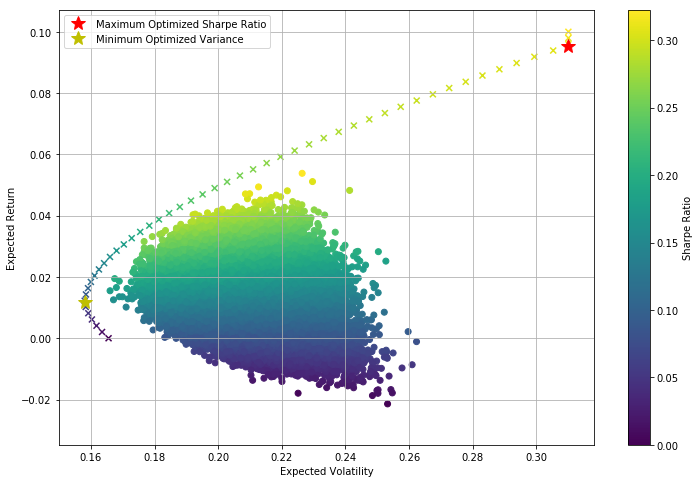

In [31]:
plt.figure(figsize=(12, 8))
plt.scatter(pvols, prets,
            c=np.array(prets) / np.array(pvols), marker='o')
            # random portfolio composition
    
plt.scatter(tvols, trets,
            c=np.array(trets) / np.array(tvols), marker='x')
            # efficient frontier
    
plt.plot(statistics(opts['x'])[1], 
         statistics(opts['x'])[0],
         'r*', markersize=15.0,
         label="Maximum Optimized Sharpe Ratio")
            # portfolio with highest Sharpe ratio
    
plt.plot(statistics(optv['x'])[1], 
         statistics(optv['x'])[0],
         'y*', markersize=15.0,
         label="Minimum Optimized Variance")
            # minimum variance portfolio
    
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.legend(loc='upper left')
plt.colorbar(label='Sharpe Ratio');

In the above chart, the crosses indicate the optimal portfolios given a certain target return.  In addition, the figure shows two stars:
* One for the portfolio with the Maximum Optimized Sharpe Ratio (red)
* One for the Minimum Optimized Variance (yellow)     

Notice that the Optimized Maximum Sharpe Ratio portfolio is nowhere near any of the simulated portfolios we generated.  This is due to the fact that its weights (100% in XLE) are extreme and virtually impossible to simulate given our randomized approach used above.

### Risk-Return Tradeoff

We've visualized the Efficient Frontier and discussed how acts as a function of risk versus return, but let's explore the gradient of sector weightings that contribute to the risk-return tradeoff at each point of this curve.

In the below plot, we show the sector weightings of various portfolios as we target incrementally higher return levels along the Efficient Frontier.

In [32]:
e_weights_all.head(1)

,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLK,XLU,exp_return,exp_volatility,sharpe_ratio
0,2.456062e-17,0.641515,3.155779e-18,1.827646e-17,0.144423,3.302910e-17,0.0,0.154473,0.059589,0.0,0.165545,0.0


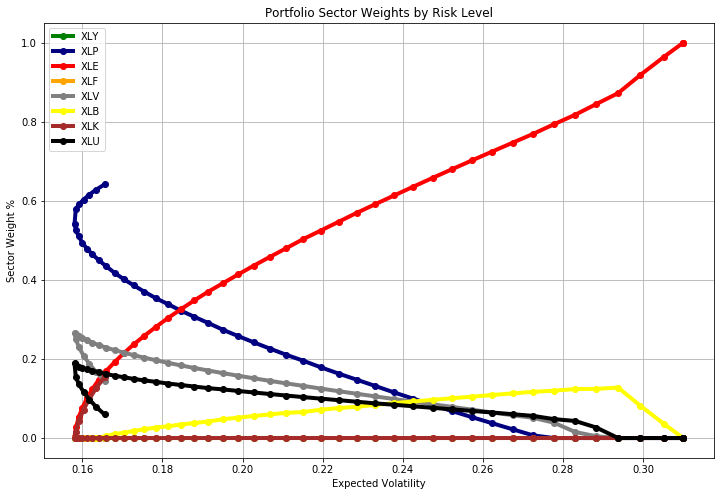

In [33]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(e_weights_all['exp_volatility'],
    e_weights_all['XLY'],
        marker='o', c='green', linewidth=4,label="XLY")

ax.plot(e_weights_all['exp_volatility'],
    e_weights_all['XLP'],
        marker='o', c='navy', linewidth=4,label="XLP")

ax.plot(e_weights_all['exp_volatility'],
    e_weights_all['XLE'],
        marker='o', c='red', linewidth=4,label="XLE")

ax.plot(e_weights_all['exp_volatility'],
    e_weights_all['XLF'],
        marker='o', c='orange', linewidth=4,label="XLF")

ax.plot(e_weights_all['exp_volatility'],
    e_weights_all['XLV'],
        marker='o', c='grey', linewidth=4,label="XLV")

ax.plot(e_weights_all['exp_volatility'],
    e_weights_all['XLB'],
        marker='o', c='yellow', linewidth=4,label="XLB")

ax.plot(e_weights_all['exp_volatility'],
    e_weights_all['XLK'],
        marker='o', c='brown', linewidth=4,label="XLK")

ax.plot(e_weights_all['exp_volatility'],
    e_weights_all['XLU'],
        marker='o', c='black', linewidth=4,label="XLU")

plt.title("Portfolio Sector Weights by Risk Level")
plt.xlabel("Expected Volatility")
plt.ylabel("Sector Weight %")
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

We see that in a bid to capture greater return for given levels of risk, the sector of choice which holds high weightings is XLE, and to a lesser extent XLB.  XLP, which holds a high allocation when risk tolerance is low is steadily reduced as more risk is taken on.  Every other sector is reduced as well aside from XLE.

# Exploring Portfolio Strategies
So far we have optimized for the portfolios which yield the Maximum Sharpe Ratio and Minimum Variance.  We've seen how, in the case of the optimal Sharpe Ratio, the cost is a 100% XLE-weighted portfolio.  

While this portfolio has a high Sharpe Ratio, it also has a very high Expected Volatility.  It is also most likely unwise toput all of our capital into a single sector.  If that sector were to suffer a downturn, we would have no diversification in other areas to offset potential losses.

To take a more convservative (and realistic) approach to planning our investment strategy, let's look again at the simulated portfolio data we generated.

We will select test portfolios through the following ways:
* Highest Sharpe Ratio of all simulated portfolios
* Weighted Average Among the 99th percentile of simulated portfolio Sharpe Ratios (weighted by Sharpe Ratio)
* Weighted Average Among across all simulated portfolios (weighted by Sharpe Ratio)
* Equally Weighted

Using these approaches, we will select distinct portfolios and see how they performed on both the training and test sets.

## Highest Simulated Sharpe Ratio

The simulated with the highest Sharpe Ratio is one where nearly a third of the weight is in XLB, followed by a near even split in XLU and XLE.  A very small amount is allocated to other sectors, with less than a percent for both XLF and XLK.

In [34]:
sim_highest_sharpe = weights_all_train.sort_values(by="sharpe_ratio",ascending=False).head(1)

In [35]:
sim_highest_sharpe = sim_highest_sharpe[sim_highest_sharpe.columns.difference(['exp_return',
                                           'sharpe_ratio',
                                           'exp_volatility'])].T.sort_values(by=0,ascending=False).squeeze()
sim_highest_sharpe

XLE    0.465266
XLP    0.177944
XLB    0.156043
XLI    0.100266
XLF    0.034303
XLY    0.033225
XLU    0.015622
XLK    0.011503
XLV    0.005829
Name: 0, dtype: float64

In [36]:
sim_highest_sharpe = sim_highest_sharpe.reindex(rets_test.columns).values

In [37]:
print("Expected Return: "+str(statistics(sim_highest_sharpe)[0]))
print("Expected Volatility: "+str(statistics(sim_highest_sharpe)[1]))
print("Sharpe Ratio: "+str(statistics(sim_highest_sharpe)[2]))

Expected Return: 0.0538159603872
Expected Volatility: 0.226387093801
Sharpe Ratio: 0.237716556557


## Weighted Average Among Top Sharpe Ratio Percentile

Looking at the simulated portfolios within the 99th percentile of Sharpe Ratios, we see a similar weighting distribution as the above portfolio.  XLE, XLB, and XLU have the highest weights, however this time more weight is placed on XLV, XLP and XLI.  Again, XLK and XLF earn the least weightings.

In [38]:
sim_top_ptile_sharpe = weights_all_train[weights_all_train['sharpe_ratio'] > weights_all_train['sharpe_ratio'].quantile(.99)]

In [39]:
sim_top_ptile_sharpe = sim_top_ptile_sharpe[sim_top_ptile_sharpe.columns.difference(['exp_return',
                                           'sharpe_ratio',
                                           'exp_volatility'])].apply(lambda x: np.ma.average(
                    np.ma.MaskedArray(x, mask=np.isnan(x)), 
                    weights=sim_top_ptile_sharpe.sharpe_ratio)).sort_values(ascending=False)

In [40]:
sim_top_ptile_sharpe

XLE    0.237518
XLB    0.167388
XLU    0.136230
XLV    0.111271
XLP    0.109049
XLI    0.099718
XLY    0.076460
XLK    0.031799
XLF    0.030567
dtype: float64

In [41]:
sim_top_ptile_sharpe = sim_top_ptile_sharpe.reindex(rets_test.columns).values

In [42]:
print("Expected Return: "+str(statistics(sim_top_ptile_sharpe)[0]))
print("Expected Volatility: "+str(statistics(sim_top_ptile_sharpe)[1]))
print("Sharpe Ratio: "+str(statistics(sim_top_ptile_sharpe)[2]))

Expected Return: 0.0362047264092
Expected Volatility: 0.201462790758
Sharpe Ratio: 0.179709246918


## Weighted Average by Sharpe Ratio

Finally, we take a weighted average of sector weightings across our entire training dataset, weighted by Sharpe Ratio.

Again, we see that XLE is the top weighted sector, followed by XLB.  XLF and XLK are the least weighted sectors.  However, this time we see a much more even weighting across all sectors.

In [43]:
sim_wtd_all_sharpe = weights_all_train[weights_all_train.columns.difference(['exp_return',
                                           'sharpe_ratio',
                                           'sharpe_ratio',
                                           'exp_volatility'])].apply(lambda x: np.ma.average(
                    np.ma.MaskedArray(x, mask=np.isnan(x)), 
                    weights=weights_all_train.sharpe_ratio)).sort_values(ascending=False)
sim_wtd_all_sharpe

XLE    0.137051
XLB    0.122396
XLU    0.115981
XLV    0.112547
XLI    0.111344
XLP    0.110692
XLY    0.107289
XLF    0.091997
XLK    0.090703
dtype: float64

In [44]:
sim_wtd_all_sharpe = sim_wtd_all_sharpe.reindex(rets_test.columns).values

In [45]:
print("Expected Return: "+str(statistics(sim_wtd_all_sharpe)[0]))
print("Expected Volatility: "+str(statistics(sim_wtd_all_sharpe)[1]))
print("Sharpe Ratio: "+str(statistics(sim_wtd_all_sharpe)[2]))

Expected Return: 0.018907748496
Expected Volatility: 0.203133011132
Sharpe Ratio: 0.093080629242


## Equally Weighted

Finally, we will also throw in an equally weighted portfolio with ~11% in each sector.

In [46]:
pd.DataFrame(x0,index=rets_test.columns)

,0
XLY,0.111111
XLP,0.111111
XLE,0.111111
XLF,0.111111
XLV,0.111111
XLI,0.111111
XLB,0.111111
XLK,0.111111
XLU,0.111111


In [47]:
equal_wtd_port = statistics(x0)

In [48]:
print("Expected Return: "+str(statistics(x0)[0]))
print("Expected Volatility: "+str(statistics(x0)[1]))
print("Sharpe Ratio: "+str(statistics(x0)[2]))

Expected Return: 0.013996286911
Expected Volatility: 0.205182688612
Sharpe Ratio: 0.0682137806346


## Comparison on Training Set

Below we show a comparison of Expected Return, Expected Volatility and Sharpe Ratio across out six test portfolios and the Efficient Frontier.

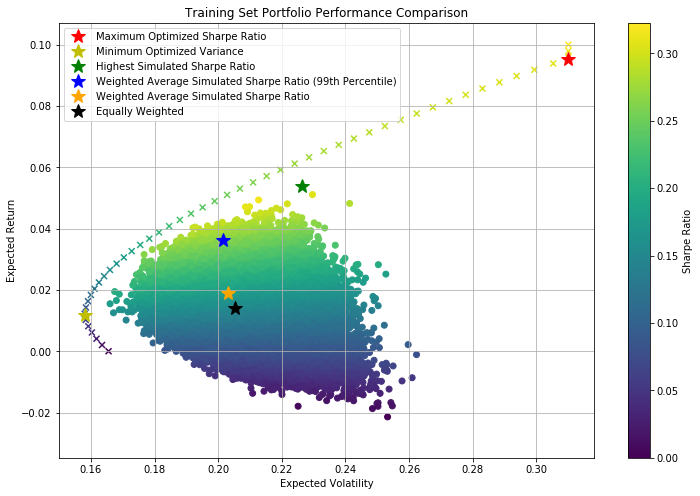

In [49]:
plt.figure(figsize=(12, 8))
plt.scatter(pvols, prets,
            c=np.array(prets) / np.array(pvols), marker='o')
            # random portfolio composition
plt.scatter(tvols, trets,
            c=np.array(trets) / np.array(tvols), marker='x')
            # efficient frontier

#Optimal Portfolios    
plt.plot(statistics(opts['x'])[1], 
         statistics(opts['x'])[0],
         'r*', markersize=15.0,
         label="Maximum Optimized Sharpe Ratio")
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], 
         statistics(optv['x'])[0],
         'y*', markersize=15.0,
         label="Minimum Optimized Variance")
            # minimum variance portfolio

#Simulated Portfolios
plt.plot(statistics(sim_highest_sharpe)[1], 
         statistics(sim_highest_sharpe)[0],
         'y*', markersize=15.0,c="green",
         label="Highest Simulated Sharpe Ratio")
            # minimum variance portfolio
    
plt.plot(statistics(sim_top_ptile_sharpe)[1], 
         statistics(sim_top_ptile_sharpe)[0],
         'y*', markersize=15.0,c="blue",
        label="Weighted Average Simulated Sharpe Ratio (99th Percentile)")
            # minimum variance portfolio
    
plt.plot(statistics(sim_wtd_all_sharpe)[1], 
         statistics(sim_wtd_all_sharpe)[0],
         'y*', markersize=15.0,c="orange",
        label="Weighted Average Simulated Sharpe Ratio")
            # minimum variance portfolio
    
plt.plot(statistics(x0)[1], 
         statistics(x0)[0],
         'y*', markersize=15.0,c="black",
        label="Equally Weighted")
            # minimum variance portfolio
    
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.legend(loc='upper left')
plt.colorbar(label='Sharpe Ratio');
plt.title("Training Set Portfolio Performance Comparison");

We see that of our six portfolio strategies, the portfolio with the Optimized Maximum Sharpe Ratio has the highest Sharpe Ratio.  The second highest belongs to the portfolio with the Highest Sharpe Ratio from the simulated data.  

# Test Portfolio Performance

Now, we have looked at six portfolio strategies based on the training set.  We will now assess the performance of these strategies on the test set.  To recap, the we have assembled the following portfolios to test:

* Maximum Optimized Sharpe Ratio
* Minimum Optimized Variance
* Equally Weighted
* Highest Simulated Sharpe Ratio
* Weighted Average Simulated Sharpe Ratio (99th Percentile)
* Weighted Average Simulated Sharpe Ratio

As we did with the training set, let's re-run our Monte Carlo simulation on the test set which contains data from June 2009 to October 2017.

In [50]:
prets = []
pvols = []
for p in range(100000):
    #initialize weights
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    #append returns to list
    prets.append(np.sum(rets_test.mean()*weights)*252)
    #append volatilities to list
    pvols.append(np.sqrt(np.dot(weights.T,
                               np.dot(rets_test.cov()*252,weights))))
    
    weights = pd.DataFrame(weights)
    weights = weights.T
    
    if p == 0:
        weights_all_test = weights
    else:
        weights_all_test = pd.concat([weights_all_test,weights])

prets = np.array(prets)
pvols = np.array(pvols)
weights_all_test.columns = data.columns
weights_all_test['exp_return'] = prets
weights_all_test['exp_volatility'] = pvols
weights_all_test['sharpe_ratio'] = prets/pvols

In [51]:
def new_statistics(weights):
    '''Returns portfolio statistics
    Parameters
    ==========
    pret : float
        expected portfolio return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    pret = np.sum(rets_test.mean()*weights)*252
    pvol = np.sqrt(np.dot(weights.T,np.dot(rets_test.cov()*252,weights)))
    return np.array([pret,pvol,pret/pvol])

In [52]:
e_weights_all['new_exp_return'] = ""
e_weights_all['new_exp_volatility'] = ""
e_weights_all['new_sharpe_ratio'] = ""
e_weights_all.reset_index(inplace=True)

In [53]:
trets = []
tvols = []
for idx, row in e_weights_all.iterrows():
    exp_return, exp_variance, sharpe_ratio = new_statistics(row[["XLY","XLP","XLE","XLF","XLV","XLI","XLB","XLK","XLU"]])
    trets.append(exp_return)
    tvols.append(exp_variance)

In [54]:
print("Highest Simulated Sharpe Ratio: ")
print("___________________________________")
print("Expected Return: "+str(new_statistics(sim_highest_sharpe)[0]))
print("Expected Volatility: "+str(new_statistics(sim_highest_sharpe)[1]))
print("Sharpe Ratio: "+str(new_statistics(sim_highest_sharpe)[2]))

Highest Simulated Sharpe Ratio: 
___________________________________
Expected Return: 0.0940433033772
Expected Volatility: 0.173871245232
Sharpe Ratio: 0.540878989231


In [55]:
print("Weighted Average Simulated Sharpe Ratio (99th Percentile): ")
print("___________________________________")
print("Expected Return: "+str(new_statistics(sim_top_ptile_sharpe)[0]))
print("Expected Volatility: "+str(new_statistics(sim_top_ptile_sharpe)[1]))
print("Sharpe Ratio: "+str(new_statistics(sim_top_ptile_sharpe)[2]))

Weighted Average Simulated Sharpe Ratio (99th Percentile): 
___________________________________
Expected Return: 0.116511916705
Expected Volatility: 0.153085338749
Sharpe Ratio: 0.761091281876


In [56]:
print("Weighted Average Simulated Sharpe Ratio: ")
print("___________________________________")
print("Expected Return: "+str(new_statistics(sim_wtd_all_sharpe)[0]))
print("Expected Volatility: "+str(new_statistics(sim_wtd_all_sharpe)[1]))
print("Sharpe Ratio: "+str(new_statistics(sim_wtd_all_sharpe)[2]))

Weighted Average Simulated Sharpe Ratio: 
___________________________________
Expected Return: 0.13157729767
Expected Volatility: 0.149552114086
Sharpe Ratio: 0.879809011552


In [57]:
print("Maximum Optimized Sharpe Ratio: ")
print("___________________________________")
print("Expected Return: "+str(new_statistics(optimal_sharpe.T.values.flatten())[0]))
print("Expected Volatility: "+str(new_statistics(optimal_sharpe.T.values.flatten())[1]))
print("Sharpe Ratio: "+str(new_statistics(optimal_sharpe.T.values.flatten())[2]))

Maximum Optimized Sharpe Ratio: 
___________________________________
Expected Return: 0.0491763131607
Expected Volatility: 0.222443949852
Sharpe Ratio: 0.221072828429


In [58]:
print("Minimum Optimized Variance: ")
print("___________________________________")
print("Expected Return: "+str(new_statistics(optimal_variance.T.values.flatten())[0]))
print("Expected Volatility: "+str(new_statistics(optimal_variance.T.values.flatten())[1]))
print("Sharpe Ratio: "+str(new_statistics(optimal_variance.T.values.flatten())[2]))

Minimum Optimized Variance: 
___________________________________
Expected Return: 0.1316111457
Expected Volatility: 0.115162490209
Sharpe Ratio: 1.14282997407


In [59]:
print("Equallty Weighted: ")
print("___________________________________")
print("Expected Return: "+str(new_statistics(x0)[0]))
print("Expected Volatility: "+str(new_statistics(x0)[1]))
print("Sharpe Ratio: "+str(new_statistics(x0)[2]))

Equallty Weighted: 
___________________________________
Expected Return: 0.13544796998
Expected Volatility: 0.149096832506
Sharpe Ratio: 0.908456388396


## Comparison on Test Set

The below plot shows the performance of our chosen portfolio strategies on the test set.  Also included is the portfolio weightings that comprised the Efficient Frontier from the training set.

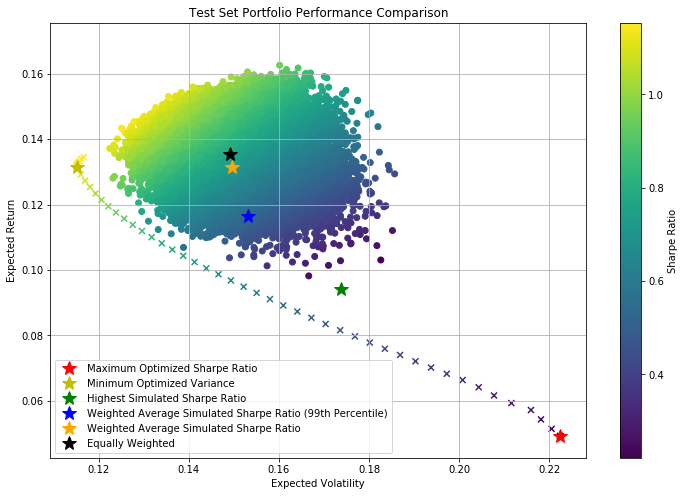

In [60]:
plt.figure(figsize=(12, 8))
plt.scatter(pvols, prets,
            c=np.array(prets) / np.array(pvols), marker='o')
            # random portfolio composition

plt.scatter(tvols, trets,
            c=np.array(trets) / np.array(tvols), marker='x')
            # efficient frontier

#Optimal Portfolios    
plt.plot(new_statistics(opts['x'])[1], 
         new_statistics(opts['x'])[0],
         'r*', markersize=15.0,
         label="Maximum Optimized Sharpe Ratio")
            # portfolio with highest Sharpe ratio
plt.plot(new_statistics(optv['x'])[1], 
         new_statistics(optv['x'])[0],
         'y*', markersize=15.0,
         label="Minimum Optimized Variance")
            # minimum variance portfolio

#Simulated Portfolios
plt.plot(new_statistics(sim_highest_sharpe)[1], 
         new_statistics(sim_highest_sharpe)[0],
         'y*', markersize=15.0,c="green",
         label="Highest Simulated Sharpe Ratio")
                
plt.plot(new_statistics(sim_top_ptile_sharpe)[1], 
         new_statistics(sim_top_ptile_sharpe)[0],
         'y*', markersize=15.0,c="blue",
        label="Weighted Average Simulated Sharpe Ratio (99th Percentile)")
    
plt.plot(new_statistics(sim_wtd_all_sharpe)[1], 
         new_statistics(sim_wtd_all_sharpe)[0],
         'y*', markersize=15.0,c="orange",
        label="Weighted Average Simulated Sharpe Ratio")
    
plt.plot(new_statistics(x0)[1], 
         new_statistics(x0)[0],
         'y*', markersize=15.0,c="black",
        label="Equally Weighted")
    
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.legend(loc='bottom left')
plt.colorbar(label='Sharpe Ratio')
plt.title("Test Set Portfolio Performance Comparison");

We see that the Efficient Frontier as represented from the training set shows a nearly opposite trend on the test set.  As we noted above, the incrementally higher proportion of each ensuing portfolio allocated to XLE contributed to this underperformance.

## Takeaways

**Perils of Chasing High Return Trends**

Looking at the performance of our portfolios, it is apparent that most of them did not perform as well on the test set as they did on the training set. The top performing portfolios by Sharpe Ratio were: Minimum Optimized Variance, Weighted Average Simulated Sharpe Ratio and Equally Weighted portfolios.

If we recall, the portfolios which were more weighted towards energy (XLE) were the Maximum Optimized Sharpe Ratio and Highest Simulated Sharpe Ratio.  This is also reflected in the Efficient Frontier's weightings. These portfolios performed much worse than the other portfolios, chiefly due to a downturn in the energy sector in late 2014, which has currently reduced its value by nearly a third.  Since these portfolios were weighted higher in this sector, they had more risk on the table than the other portfolio strategies.

**Benefits of Risk Reduction**

While the Sharpe Ratio maximizing portfolios underperformed those with greater diversification, it is important to highlight the strong performance of our Minimum Optimized Variance portfolio.  This portfolio, with the majority weighted in XLP, had the highest Sharpe Ratio by a wide margin, yet it had the second lowest Sharpe Ratio on the training set.  XLP represents the consumer staples sector, a relatively conservative index in comparison with the others.  XLP contains stocks of companies like Proctor & Gamble, Coca-Cola and Philip Morris.  While most of these companies are not at the cutting edge of technology and do not generate the highest returns, they have a level of stability that worked well across the time period represented by the test data.

**Benefits of Diversification**

Also evident, is the relatively strong performance of the Equally Eeighted and Weighted Average Simulated Sharp Ratio portfolios.  These portfolios were composed of nearly identically diversifed sector allocations which helped them buouy the downturn in energy and basic materials as well as gain from the later strong performances of the technology and financial sectors.

# Conclusion

So what have we learned from this analysis?  We have learned an important financial lesson, that is: **Past Performance Is Not Indicative of Future Results**.  In the case of our investor planning their portfolio in June 2009, the past data showed that a higher weighting in the energy sector was the most promising way to maximize the Sharpe Ratio.  However, this strategy turned out to be high risk and low return when subjected to future conditions, hence the resultingly low Sharpe Ratios across such portfolios.  

We saw that a portfolio strategy of risk reduction by creating a portfolio of low-risk assets such as XLP, had a superior Sharpe Ratio during the years following the Financial Crisis.

We also saw how diversification can create portfolios that are more robust to downturns by spreading risk equally among assets.

To make these conclusions, we used the powerful tools and concepts such as: 
* **Mean-Variance Portfolio Theory** to outline the assumptions for calculating Expected Return and Expected Volatility
* **Monte Carlo Simulation** to generate a realistically random array of sample portfolios for model training and testing
* **Optimization** to determine the optimal asset weight mix for our objectives

As always, thank you for your interest and I hope you enjoyed reading.  -Collier King

# Computing Environment/Specs Used

## Platform/OS

In [61]:
import platform
print("Platform:"+str(platform.system())+str(platform.architecture()))
print("..."+str(platform.release())+str(platform.version()))

Platform:Windows('64bit', 'WindowsPE')
...76.1.7601


## Python Version

In [62]:
import sys
print("Python Version: "+str(sys.version))

Python Version: 3.6.0 (v3.6.0:41df79263a11, Dec 23 2016, 08:06:12) [MSC v.1900 64 bit (AMD64)]


## Packages/Libraries

In [63]:
import pandas as pd
print(pd.__name__," ",pd.__version__)
import numpy as np
print(np.__name__," ",np.__version__)
import matplotlib
print(matplotlib.__name__," ",matplotlib.__version__)
import scipy
print(scipy.__name__," ",scipy.__version__)
import pandas_datareader
print(pandas_datareader.__name__," ",pandas_datareader.__version__)
import fix_yahoo_finance
print(fix_yahoo_finance.__name__," ",fix_yahoo_finance.__version__)
import seaborn
print(seaborn.__name__," ",seaborn.__version__)

pandas   0.20.1
numpy   1.13.3
matplotlib   2.0.2
scipy   1.0.0rc1
pandas_datareader   0.5.0
fix_yahoo_finance   0.0.19
seaborn   0.8.1
